/home/rohanparab/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Sep/2024 16:31:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2024 16:31:03] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [29/Sep/2024 16:31:15] "POST / HTTP/1.1" 200 -


199
50
MSE =  1096.074765647839
RMSE =  33.10701988472896
MAPE = 0.014147692736677453
Accuracy =  98.58523072633226


127.0.0.1 - - [29/Sep/2024 16:31:52] "POST /forecast HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2024 16:31:52] "GET /static/forecast_plot.png HTTP/1.1" 200 -


5
-5
5
-5


127.0.0.1 - - [29/Sep/2024 16:31:58] "POST /buysell HTTP/1.1" 200 -


5


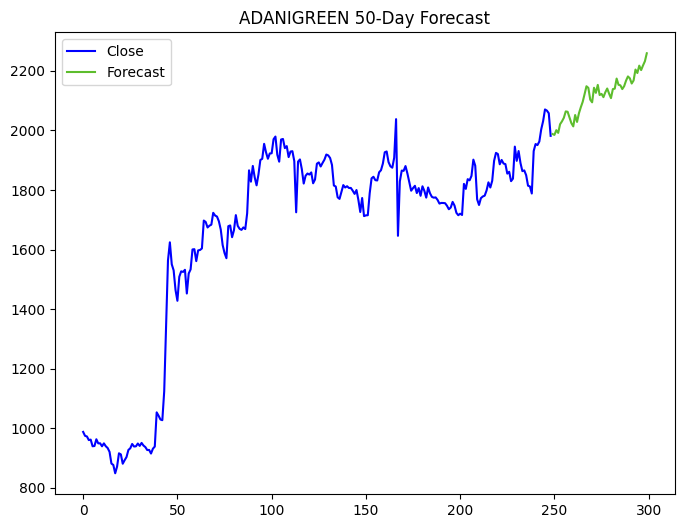

In [1]:
from flask import Flask, render_template, request
from nselib import capital_market
import yfinance as yf
import math
import os
import numpy as np
import pandas as pd
from datetime import datetime, date
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
# from flask_ngrok import run_with_ngrok
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings("ignore")
app = Flask(__name__)

# run_with_ngrok(app)

global sym, stock, rec, ebitda_margin, teps, feps, f_pe, t_pe
@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        global sym
        sym = request.form['symbol']
        sym2 = str(sym) + '.NS'
        global stock
        stock = yf.Ticker(sym2)
        info_dict = stock.info
        key_list = ['symbol', 'quoteType', 'longName', 'city', 'website', 'industry', 'fullTimeEmployees',
                    'previousClose', 'open', 'dayLow', 'dayHigh', 'fiftyTwoWeekHigh', 'dividendRate',
                    'dividendYield', 'marketCap', 'trailingPE', 'forwardPE', 'trailingEps', 'forwardEps',
                    'enterpriseToEbitda', 'debtToEquity', 'returnOnEquity', 'revenuePerShare', 'ebitdaMargins',
                    'currentPrice', 'targetHighPrice', 'targetLowPrice', 'recommendationKey']
        new_info_dict = {}
        counter = 0
        for key, value in info_dict.items():
            if key in key_list:
                counter += 1
                new_info_dict[key] = value
        df = pd.DataFrame([new_info_dict])
        
        # print(type(k))
        for key in new_info_dict.keys():
            if key == 'recommendationKey':
                global rec,ebitda_margin,teps,feps,f_pe,t_pe
                rec = str(new_info_dict['recommendationKey'])
            if key == 'ebitdaMargins':
                ebitda_margin = float(new_info_dict['ebitdaMargins'])
            if key == 'trailingEps':
                teps = float(new_info_dict['trailingEps'])
            else:
                teps=0
            if key == 'forwardEps':
                feps = float(new_info_dict['forwardEps'])
            else:
                feps = teps
            if key == 'trailingPE':
                t_pe = float(new_info_dict['trailingPE'])
            else:
                t_pe=0
            if key == 'forwardPE':
                f_pe = float(new_info_dict['forwardPE'])
            else:
                f_pe = t_pe

    
        return render_template('index_5.html', data=df.to_html(classes='table table-striped', index=False))
    return render_template('index_5.html', data=None)  

@app.route('/forecast', methods=['POST'])
def forecast():
    global sym
    button_clicked()  # Call your forecast function
    return render_template('index_5.html', data=None, forecast_data="Forecast generated successfully.")

global train_set, test_set, future
def button_clicked():
    data = capital_market.price_volume_data(symbol=sym, period='1Y')
    df = pd.DataFrame({'Date':data['Date'], 'Close':data['ClosePrice']})
    l = len(df)
    flag = 1
    for i in range(l):
       if type(df['Close'][i]) != np.float64:
        flag = 0
    if flag == 0:
        df['Close'] = df['Close'].str.replace(',', '').astype(float)
    if flag == 1:
        df['Close'] = df['Close'].replace(',', '').astype(float)
    stepwise_fit = auto_arima(df['Close'], suppress_warnings=True)
    stepwise_fit.summary()

    n = len(df['Close'])
    train_size = int(n * 0.80)
    #train test split
    global train_set
    train_set = df.iloc[:train_size]
    global test_set
    test_set = df.iloc[train_size:]
    print(len(train_set))
    print(len(test_set))

    model = ARIMA(df['Close'], order = (31,2,31))
    model_fit = model.fit()
    start_point = len(train_set)
    end_point = len(train_set) + len(test_set) - 1
    pred = model_fit.predict(start= start_point, end = end_point, type='levels').rename('ARIMA predictions')
# pred.plot(legend=True)
# test_set['Close'].plot(legend=True)
    # MSE
    mse = mean_squared_error(pred, test_set['Close'])
    print("MSE = ",mse)
    # RMSE
    rmse = math.sqrt(mse)
    print("RMSE = ",rmse)
    # MAPE
    mape = mean_absolute_percentage_error(test_set['Close'], pred)
    print("MAPE =", mape)
    # Accuracy
    print("Accuracy = ",100-mape*100)
    #Future trend 
    global future
    future = model_fit.predict(start= len(df), end= len(df)+50, type='levels').rename("Forecast")
# print(future)

    plt.figure(figsize=(8,6))
    df['Close'].plot(color = 'blue', legend=True)
# future.plot(legend=True, title=f"{sym} 50-Day Forecast")
    flg = 0
    if future[len(df) + 50] > future[len(df)]:
        flg = 1
    if flg == 1:
        future.plot(color='#5dbd2d', legend=True, title=f"{sym} 50-Day Forecast")
    else:
        future.plot(color = 'red', legend=True, title=f"{sym} 50-Day Forecast")
        
    # Save the plot as an image
    image_path = os.path.join(app.static_folder, 'forecast_plot.png')
    plt.savefig(image_path)
    



@app.route("/buysell",methods=['POST'])
def buysell():
    weight_sum = 0
    global stock
    bal_sheet = stock.balance_sheet
    row_index='Total Capitalization'
    w=0
    #weight = 3
    c = len(bal_sheet.columns)
    print(c)
    for i in range(c):
        if (float(bal_sheet.loc[row_index,bal_sheet.columns[i]]) - float(bal_sheet.loc[row_index,bal_sheet.columns[i]])) > 0:
            w += 1
        else:
            w -= 1
    print(w)
    weight_sum += w
    
    #weight = 3
    row_index='Total Assets'
    w=0
    c = len(bal_sheet.columns)
    print(c)
    for i in range(c):
        if (float(bal_sheet.loc[row_index,bal_sheet.columns[i]]) - float(bal_sheet.loc[row_index,bal_sheet.columns[i]])) > 0:
            w += 1
        else:
            w -= 1
    print(w)
    weight_sum += w
    
    s0 = len(train_set) + len(test_set)
    s1 = s0 + 10
    s2 = s0 + 20
    s3 = s0 + 30
    s4 = s0 + 40
    s5 = s0 + 50
    def slope(x,y):
        global future
        m = (future[y] - future[x])/ (y-x)
        return m
    m1 = slope(s0,s1)
    m2 = slope(s0,s2)
    m3 = slope(s0,s3)
    m4 = slope(s0,s4)
    m5 = slope(s0,s5)
    fc = (m1 + m2 + m3 + m4 + m5)/5

#weight = 30
    if (fc > 0) and (fc <= 1):
        weight_sum += 30
    elif (fc > 1):
        weight_sum += 60
    if (fc < 0) and (fc >= -0.5):
        weight_sum -= 30
    elif (fc < -0.5):
        weight_sum -= 60  
        
    #weight = 5
    if(rec == 'strong_buy'):
        weight_sum+=10
    elif (rec == 'buy'):
        weight_sum+=5
    else:
        weight_sum-=10

    #weight = 5
    if (f_pe > t_pe):
        weight_sum += 5
    else:
        weight_sum -= 5
        
    #weight = 3
    pe = (f_pe + t_pe)/2
    if (pe > 10)and(pe < 25):
        weight_sum += 3
    else:
        weight_sum -= 3
        
    #weight = 5
    if feps > teps:
        weight_sum += 5
    else:
        weight_sum -= 5
        
    #weigth = 3
    if ebitda_margin > 0.10 :
        weight_sum += 3
    else:
        weight_sum -= 3
    
    #weight = 3
    cash_flo=stock.cash_flow
    w=0
    c = len(cash_flo.columns)
    print(c)
    row_index='Free Cash Flow'
    for i in range(c):
        v = float(cash_flo.loc[row_index, cash_flo.columns[i]])
        if v > 0:
            w += 3
        else:
            w-=3
    weight_sum += w

    F_ind = (weight_sum)/61
    recommendation = ""

    if F_ind <= -0.15:
        recommendation = "SELL"
    elif (F_ind > -0.15) and (F_ind < 0.15):
        recommendation = "HOLD"
    elif (F_ind >= 0.15) and (F_ind < 0.50):
        recommendation = "BUY"
    elif(F_ind >= 0.50):
        recommendation = "STRONG BUY"

    return render_template('index_5.html', recommendation=recommendation)

app.run()
